In [1]:
import os, sys, shutil, h5py, json
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import scipy
import numpy as np
import tensorflow as tf
import pickle
import numpy
import matplotlib.pyplot as plt
import glob

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from shutil import copy

from keras.models import Model
from keras.models import model_from_json
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, ZeroPadding2D, Permute, Reshape, Input, Flatten
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

%cd /content/gdrive/My\ Drive/Deep_Learning/Images_Cropped/

with open("Training_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  training_samples = pickle.load(handle)

with open("Test_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  test_samples = pickle.load(handle)

Mounted at /content/gdrive
/content/gdrive/My Drive/Deep_Learning/Images_Cropped


In [0]:
# Normalization functions
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

def normalization_local_equalization(image):
  #image = img_as_ubyte(image[:, :, 0]) 
  image = image[:, :, 0]
  selem = disk(40) # The neighborhood expressed as a 2-D array of 1’s and 0’s.
  return rank.equalize(image, selem=selem)/255

In [4]:
np.random.seed(45)
np.random.shuffle(training_samples)
np.random.shuffle(test_samples)

training_images = []
training_labels = []
test_images = []
test_labels = []

for picture, label, _, _ in training_samples:
  training_images.append(normalization_local_equalization(picture).reshape(420, 420, 1))
  training_labels.append(label)

for picture, label, _, _ in test_samples:
  test_images.append(normalization_local_equalization(picture).reshape(420, 420, 1))
  test_labels.append(label)

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(34, 420, 420, 1)
(420, 420, 1)


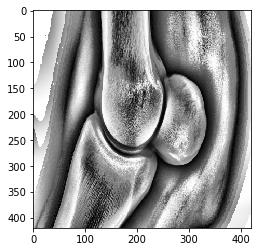

In [5]:
check_image = test_images[0]
print(test_images.shape)
print(check_image.shape)
plt.imshow(check_image[:, :, 0], cmap=plt.get_cmap('gray'))
#print(check_image)

In [6]:
def load_model(name, it):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
 
    weights = name + "_" + str(it) + '.hdf5'
    #weights = name + "_" + '.hdf5'
    print("Now Loading: " + str(name) + "_" + str(it) + ".hdf5")
    #print("Now Loading: " + str(name) + "_" + ".hdf5")
    model.load_weights(weights)
 
    return model

for m in range(10):
  save_name = 'aDilation_v1'
  model = load_model(save_name, m)
  y_predicted = model.predict(test_images)
  y_predicted_classes = np.argmax(y_predicted, axis=1)
  print((y_predicted_classes == test_labels).mean())












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Now Loading: aDilation_v1_0.hdf5
0.7058823529411765
Now Loading: aDilation_v1_1.hdf5
0.8235294117647058
Now Loading: aDilation_v1_2.hdf5
0.8235294117647058
Now Loading: aDilation_v1_3.hdf5
0.8235294117647058
Now Loading: aDilation_v1_4.hdf5
0.5
Now Loading: aDilation_v1_5.hdf5
0.7647058823529411
Now Loading: aDilation_v1_6.hdf5
0.5
Now Loading: aDilation_v1_7.hdf5
0.8823529411764706
Now Loading: aDilation_v1_8.hdf5
0.8235294117647058
Now Loading: aDilation_v1_9.hdf5
0.7058823529411765


In [7]:
# The best trained version, of the best performing model
save_name = 'aDilation_v1'
model = load_model(save_name, 7)
y_predicted = model.predict(test_images)
y_predicted_classes = np.argmax(y_predicted, axis=1)
print((y_predicted_classes == test_labels).mean())

Now Loading: aDilation_v1_7.hdf5
0.8823529411764706


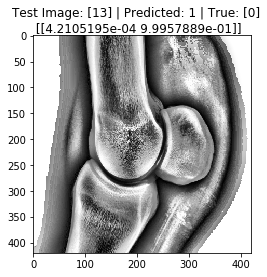

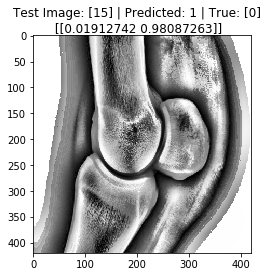

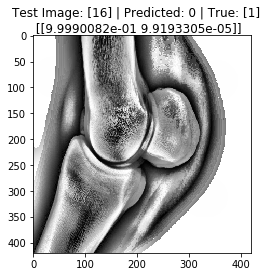

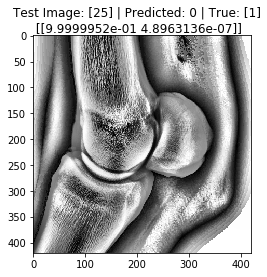

In [8]:
e = y_predicted_classes == test_labels
n_false = np.argwhere(e==False)

for n in n_false:
  check_image = test_images[n]
  y_pred = np.argmax(model.predict(check_image))
  y_true = test_labels[n]

  fig, (ax1) = plt.subplots(1, 1)
  fig.suptitle('Test Image: ' + str(n) + " | Predicted: " + str(y_pred) + " | True: " +str(y_true) + "\n " + str(model.predict(check_image)))
  ax1.imshow(check_image[0, :, :, 0], cmap=plt.get_cmap('gray'))